In [1]:
# Installing dependencies
!pip install -q kagglehub transformers peft accelerate datasets scikit-learn pandas numpy tqdm seaborn matplotlib optuna sentencepiece

import IPython
import kagglehub
import pandas as pd
import numpy as np
import torch
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import copy
import optuna
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from peft import get_peft_model, LoraConfig, TaskType
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

# Setting up the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 31.7 MB/s eta 0:00:00
Using device: cuda


## Loading and EDA - ISOT

The ISOT dataset is clean but massive. The texts provided are full articles. This is beneficial for the model to learn deep context. The 'title' and 'text' are concatenated to provide maximum information for processing.

--------------------------------------------------
                   ISOT Dataset                   
--------------------------------------------------
Using Colab cache for faster access to the 'isot-fake-news-dataset' dataset.
Success: ISOT Dataset created as a Pandas object.
Processed ISOT Dataset Shape: (44898, 2)


/tmp/ipython-input-4094696898.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_isot, palette='coolwarm')


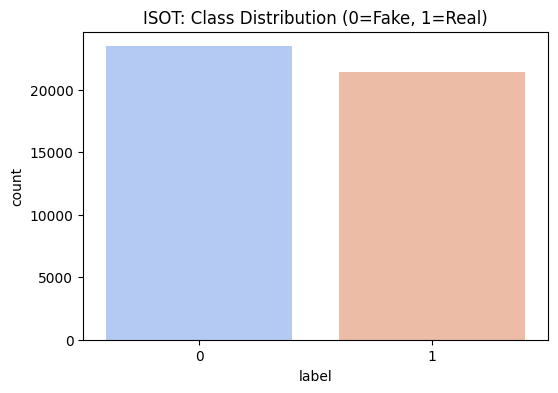

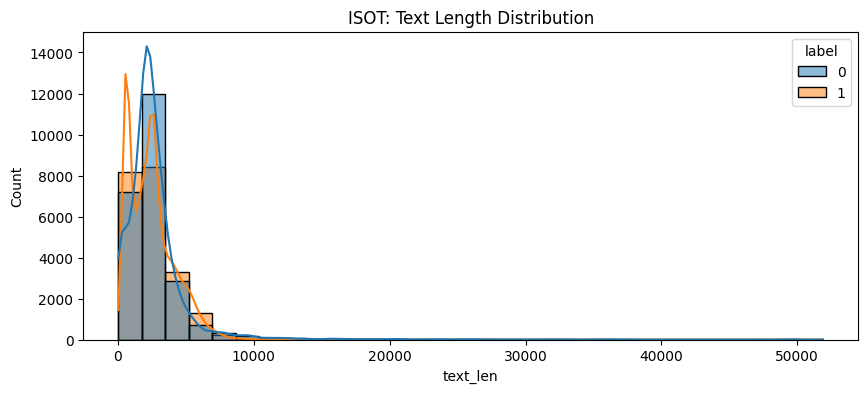


Representation of each class in the processed DataFrame:


,text,label,text_len
0,"As U.S. budget fight looms, Republicans flip t...",1,4724
21417,Donald Trump Sends Out Embarrassing New Year’...,0,2973


In [7]:
print(50*"-")
print(f"{'ISOT Dataset':^50}")
print(50*"-")

path_isot = kagglehub.dataset_download("csmalarkodi/isot-fake-news-dataset")

# Find the specific files
true_path = None
fake_path = None

for root, dirs, files in os.walk(path_isot):
    for file in files:
        if 'True.csv' in file:
            true_path = os.path.join(root, file)
        elif 'Fake.csv' in file:
            fake_path = os.path.join(root, file)

df_isot_true = pd.read_csv(true_path)
df_isot_fake = pd.read_csv(fake_path)

# Labeling
df_isot_true['label'] = 1
df_isot_fake['label'] = 0

# Combine
df_isot = pd.concat([df_isot_true, df_isot_fake], ignore_index=True)

# Verification Log
if isinstance(df_isot, pd.DataFrame) and not df_isot.empty:
    print(f"Success: ISOT Dataset created as a Pandas object.")
else:
    print("Error: Failed to create the ISOT Dataset object correctly.")

# Using 'title' + 'text' gives more context to the models
df_isot['text'] = df_isot['title'] + " " + df_isot['text']
df_isot = df_isot[['text', 'label']]

print(f"Processed ISOT Dataset Shape: {df_isot.shape}")

# EDA for ISOT
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df_isot, palette='coolwarm')
plt.title('ISOT: Class Distribution (0=Fake, 1=Real)')
plt.show()

# Check text length
df_isot['text_len'] = df_isot['text'].astype(str).apply(len)
plt.figure(figsize=(10, 4))
sns.histplot(data=df_isot, x='text_len', hue='label', kde=True, bins=30)
plt.title('ISOT: Text Length Distribution')
plt.show()

# Show a sample for each label
print("\nRepresentation of each class in the processed DataFrame:")
samples = df_isot.groupby('label').head(1)
display(samples)

## Loading and EDA - FakeNewsNet

FakeNewsNet is used as the secondary dataset. It was noticed that the dataset structure is nested, so a script was written to walk through the directories and locate the CSV files. The 'title' and 'text' columns is selected for analysis.

--------------------------------------------------
               FakeNewsNet Dataset                
--------------------------------------------------
Using Colab cache for faster access to the 'fakenewsnet' dataset.
Success: FakeNewsNet Dataset created as a Pandas object.
Processed FakeNewsNet Shape: (422, 2)


/tmp/ipython-input-2819126497.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_fnn, palette='viridis')


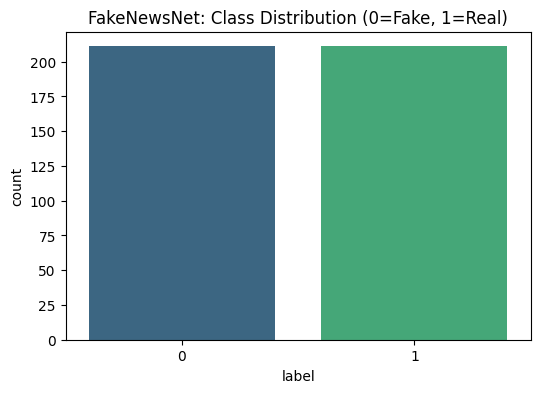

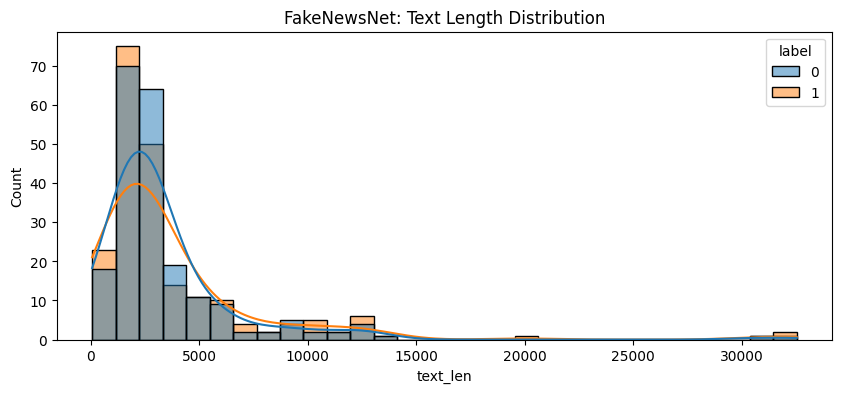


Representation of each class in the processed DataFrame:


,text,label,text_len
0,Trump Just Insulted Millions Who Lost Everythi...,1,1448
120,Trump Just Insulted Millions Who Lost Everythi...,0,1448


In [8]:
print(50*"-")
print(f"{'FakeNewsNet Dataset':^50}")
print(50*"-")

path_fnn = kagglehub.dataset_download("mdepak/fakenewsnet")

# Helper function to find CSVs
def load_fnn_data(base_path):
    dfs = []
    # Standard filenames the dataset
    targets = ['PolitiFact_real_news_content.csv', 'PolitiFact_fake_news_content.csv', 'BuzzFeed_real_news_content.csv', 'BuzzFeed_fake_news_content.csv']

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file in targets:
                full_path = os.path.join(root, file)
                df_temp = pd.read_csv(full_path)

                # Assign labels based on filename
                if 'real' in file:
                    df_temp['label'] = 1
                else:
                    df_temp['label'] = 0

                if 'title' in df_temp.columns:
                    df_temp['text'] = df_temp['title'] + " " + df_temp['text']
                    df_temp = df_temp[['text', 'label']]
                    dfs.append(df_temp)

    return pd.concat(dfs, ignore_index=True)

df_fnn = load_fnn_data(path_fnn)

# Verification Log
if isinstance(df_fnn, pd.DataFrame) and not df_fnn.empty:
    print(f"Success: FakeNewsNet Dataset created as a Pandas object.")
else:
    print("Error: Failed to create the FakeNewsNet Dataset object correctly.")
print(f"Processed FakeNewsNet Shape: {df_fnn.shape}")

# EDA for FakeNewsNet
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df_fnn, palette='viridis')
plt.title('FakeNewsNet: Class Distribution (0=Fake, 1=Real)')
plt.show()

# Check text length
df_fnn['text_len'] = df_fnn['text'].astype(str).apply(len)
plt.figure(figsize=(10, 4))
sns.histplot(data=df_fnn, x='text_len', hue='label', kde=True, bins=30)
plt.title('FakeNewsNet: Text Length Distribution')
plt.show()

# Show a sample for each label
print("\nRepresentation of each class in the processed DataFrame:")
samples = df_fnn.groupby('label').head(1)
display(samples)

## Loading and EDA - LIAR

The LIAR dataset was the most difficult to handle. Headers are missing (as it is a TSV file), and the labels are not binary. A mapping dictionary had to be created to convert these 6 classes into simply Real (1) vs Fake (0).

--------------------------------------------------
                   LIAR Dataset                   
--------------------------------------------------
Using Colab cache for faster access to the 'liar-fake-news-dataset' dataset.
Success: LIAR Dataset created as a Pandas object.
Processed LIAR Dataset Shape: (12791, 2)


/tmp/ipython-input-2632241948.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_liar, palette='magma')


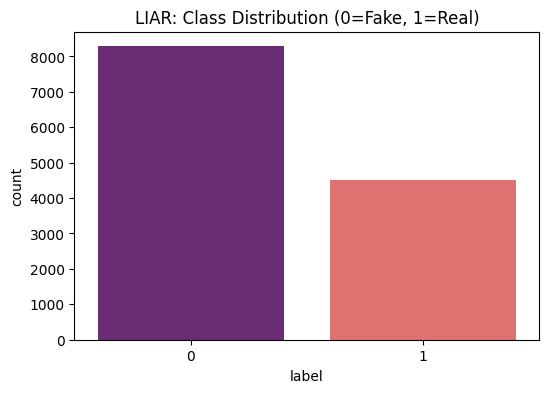

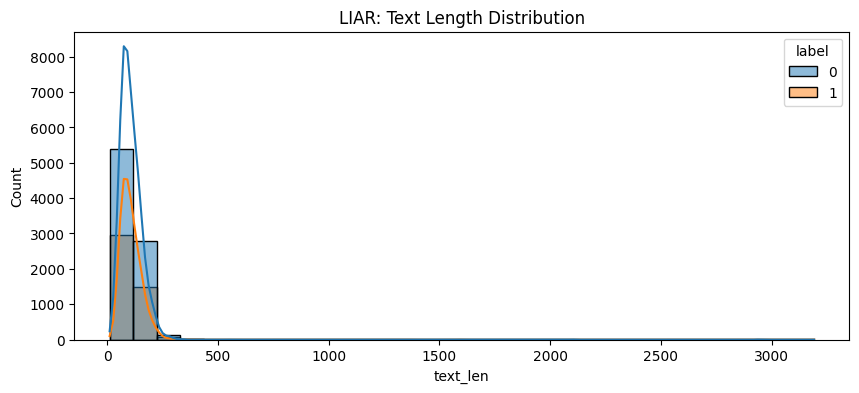


Representation of each class in the processed DataFrame:


,text,label,text_len
0,Building a wall on the U.S.-Mexico border will...,1,68
1,Wisconsin is on pace to double the number of l...,0,63


In [9]:
print(50*"-")
print(f"{'LIAR Dataset':^50}")
print(50*"-")

path_liar = kagglehub.dataset_download("csmalarkodi/liar-fake-news-dataset")

# Helper function to find TSVs
def load_liar_tsv(root_path):
    dfs = []
    # Column names based on dataset documentation
    cols = ['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party',
            'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context']

    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.endswith('.tsv'):
                full_path = os.path.join(root, file)
                try:
                    temp = pd.read_csv(full_path, sep='\t', header=None, names=cols, on_bad_lines='skip')
                    dfs.append(temp)
                except Exception as e:
                    print(f"Skipping {file} due to error: {e}")
    return pd.concat(dfs, ignore_index=True)

df_liar = load_liar_tsv(path_liar)

# Mapping 6 classes to 2 (Binary)
label_map = {
    'true': 1,
    'mostly-true': 1,
    'half-true': 0,
    'barely-true': 0,
    'false': 0,
    'pants-fire': 0
}

df_liar['binary_label'] = df_liar['label'].map(label_map)
df_liar = df_liar[['statement', 'binary_label']].rename(columns={'statement': 'text', 'binary_label': 'label'})
df_liar.dropna(inplace=True) # Drop any rows where mapping failed

# Verification Log
if isinstance(df_liar, pd.DataFrame) and not df_liar.empty:
    print(f"Success: LIAR Dataset created as a Pandas object.")
else:
    print("Error: Failed to create the LIAR Dataset object correctly.")
print(f"Processed LIAR Dataset Shape: {df_liar.shape}")

# EDA for LIAR
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df_liar, palette='magma')
plt.title('LIAR: Class Distribution (0=Fake, 1=Real)')
plt.show()

# Check text length
df_liar['text_len'] = df_liar['text'].astype(str).apply(len)
plt.figure(figsize=(10, 4))
sns.histplot(data=df_liar, x='text_len', hue='label', kde=True, bins=30)
plt.title('LIAR: Text Length Distribution')
plt.show()

# Show a sample for each label
print("\nRepresentation of each class in the processed DataFrame:")
samples = df_liar.groupby('label').head(1)
display(samples)

## Merge, Clean, and Split

All datasets are merged before splitting. This is considered crucial to prevent data leakage. If splitting were done first followed by vectorization, information from the test set might accidentally be used.

A 3-way split was created:

Train (70%): Used to teach the model.

Validation (15%): Used to tune hyperparameters.

Test (15%): Kept until the final evaluation.

In [5]:
# Merge all datasets
df_final = pd.concat([df_fnn, df_isot, df_liar], ignore_index=True)

# Clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text) # remove brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove urls
    text = re.sub(r'<.*?>+', '', text) # remove html tags
    return text

df_final['text'] = df_final['text'].apply(clean_text)
df_final = df_final.sample(frac=1, random_state=422).reset_index(drop=True)

# ********************
# Stratified Splitting
# ********************

# Separate Test
X_temp, X_test, y_temp, y_test = train_test_split(
    df_final['text'], df_final['label'],
    test_size=0.15, random_state=422, stratify=df_final['label']
)

# Separate Train and Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765, random_state=422, stratify=y_temp
)

print(f"Training Set Size: {len(X_train)}")
print(f"Validation Set Size: {len(X_val)}")
print(f"Test Set Size: {len(X_test)}")

Training Set Size: 40675
Validation Set Size: 8719
Test Set Size: 8717


## Hyperparameter Tuning of Baseline Models

For every algorithm, each hyperparameter combination is trained on the Training Set and evaluated on the Validation Set. The results for every combination are printed to ensuring transparency in the selection process. The configuration with the highest validation accuracy is identified as the best model and stored for the final testing phase.

In [6]:
# Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_val_vec = tfidf.transform(X_val)
X_test_vec = tfidf.transform(X_test)

# Defining models and parameter grids
model_configs = {
    "Logistic Regression": {
        "class": LogisticRegression,
        "fixed_params": {"max_iter": 1000, "solver": "liblinear"},
        "grid": {"C": [0.1, 1.0, 10.0]}
    },
    "Naive Bayes": {
        "class": MultinomialNB,
        "fixed_params": {},
        "grid": {"alpha": [0.1, 0.5, 1.0]}
    },
    "Linear SVM": {
        "class": LinearSVC,
        "fixed_params": {"dual": False},
        "grid": {"C": [0.1, 1.0, 5.0]}
    },
    "Random Forest": {
        "class": RandomForestClassifier,
        "fixed_params": {"n_jobs": -1},
        "grid": {"n_estimators": [50, 100], "max_depth": [None, 20]}
    }
}

best_baselines = {}
print(50*"-")
print(f"{'Hyperparameter Tuning (Train and Validation)':^50}")
print(50*"-")


for name, config in model_configs.items():
    print(f"\nModel: {name}")
    print("-" * 60)

    best_val_score = 0
    best_model = None
    best_params = {}

    # Generate all combinations of parameters
    keys, values = zip(*config['grid'].items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    for params in param_combinations:
        current_params = {**config['fixed_params'], **params}

        # Train
        model = config['class'](**current_params)
        model.fit(X_train_vec, y_train)

        # Evaluate
        val_preds = model.predict(X_val_vec)
        val_acc = accuracy_score(y_val, val_preds)

        print(f"  • Params: {str(params):<30} | Val Acc: {val_acc:.4f}")

        # Track the Best
        if val_acc > best_val_score:
            best_val_score = val_acc
            best_model = model
            best_params = params

    # Save the best model
    best_baselines[name] = best_model
    print("-" * 60)
    print(f"Best Parameters: {best_params} (Val Acc: {best_val_score:.4f})")

KeyboardInterrupt: 

The optimized baseline models are evaluated on the Test Set. To ensure a comprehensive analysis, the visualization is applied here. For each model, a side-by-side view of the Confusion Matrix and a Heatmap of the classification metrics is generated, providing a granular assessment of performance on unseen data.


----------------------------------------------------------------------
                      Final Test Set Evaluation                       
----------------------------------------------------------------------


--------------------------------------------------
Model: Logistic Regression
--------------------------------------------------
Class      | Precision  | Recall     | F1-Score  
Fake       | 0.8926     | 0.9325     | 0.9121 
Real       | 0.9126     | 0.8628     | 0.8870 

Overall Accuracy: 0.9011


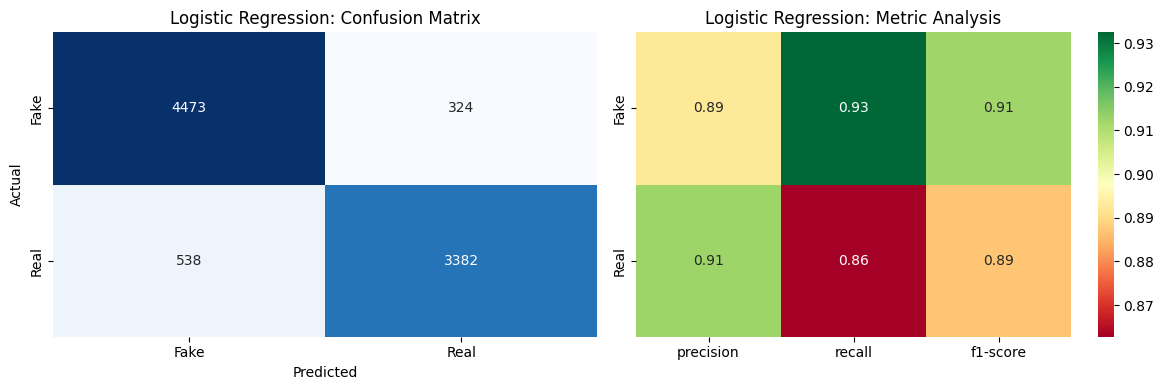


--------------------------------------------------
Model: Naive Bayes
--------------------------------------------------
Class      | Precision  | Recall     | F1-Score  
Fake       | 0.8602     | 0.8939     | 0.8767 
Real       | 0.8636     | 0.8222     | 0.8424 

Overall Accuracy: 0.8616


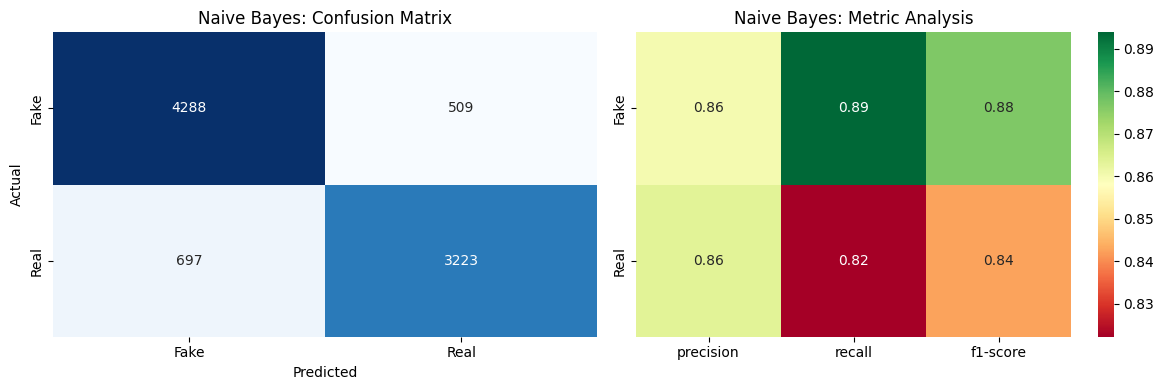


--------------------------------------------------
Model: Linear SVM
--------------------------------------------------
Class      | Precision  | Recall     | F1-Score  
Fake       | 0.8898     | 0.9391     | 0.9138 
Real       | 0.9201     | 0.8577     | 0.8878 

Overall Accuracy: 0.9025


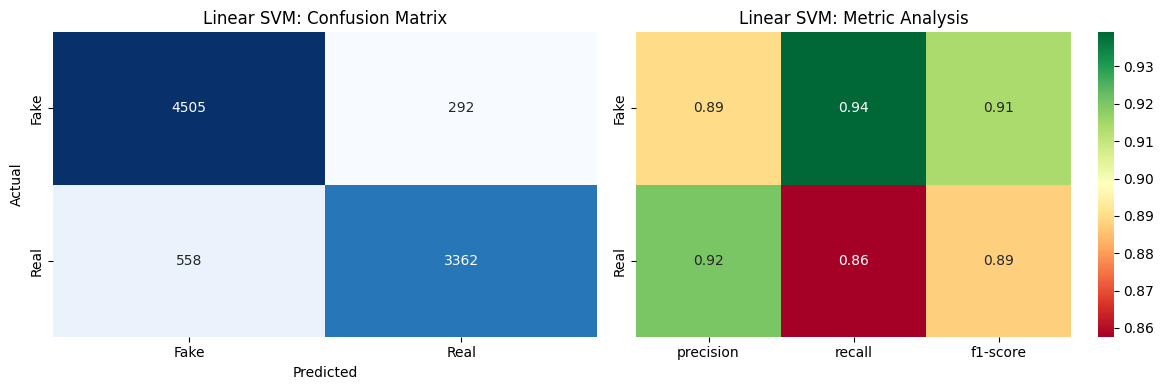


--------------------------------------------------
Model: Random Forest
--------------------------------------------------
Class      | Precision  | Recall     | F1-Score  
Fake       | 0.8661     | 0.9950     | 0.9261 
Real       | 0.9925     | 0.8117     | 0.8931 

Overall Accuracy: 0.9126


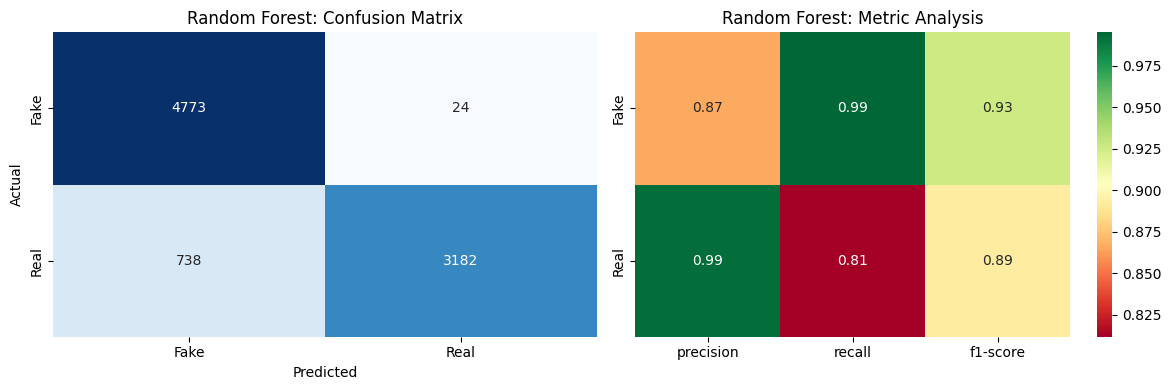

In [ ]:
# Test Set
print("\n" + 70*"-")
print(f"{'Final Test Set Evaluation':^70}")
print(70*"-" + "\n")

for name, model in best_baselines.items():
    # Predictions on Test Set
    test_pred = model.predict(X_test_vec)

    # Generate Report
    report = classification_report(y_test, test_pred, target_names=['Fake', 'Real'], output_dict=True)

    # Textual Log
    print('\n' + 50*"-")
    print(f"Model: {name}")
    print(f"{'-'*50}")
    print(f"{'Class':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
    for label in ['Fake', 'Real']:
        metrics = report[label]
        print(f"{label:<10} | {metrics['precision']:<7.4f}    | {metrics['recall']:<9.4f}  | {metrics['f1-score']:<7.4f}")
    print(f"\nOverall Accuracy: {report['accuracy']:.4f}")

    # Visual Log
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
    ax[0].set_title(f'{name}: Confusion Matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    ax[0].set_xticklabels(['Fake', 'Real'])
    ax[0].set_yticklabels(['Fake', 'Real'])

    # Classification Metrics Heatmap
    report_df = pd.DataFrame(report).iloc[:-1, :2].T
    sns.heatmap(report_df, annot=True, cmap='RdYlGn', ax=ax[1], cbar=True)
    ax[1].set_title(f'{name}: Metric Analysis')

    plt.tight_layout()
    plt.show()

# Transfer Learning
## DeBERTa & LoRA Preparation
The Deep Learning model is prepared using DeBERTa v3 Base. LoRA is implemented to ensure efficient training on the available GPU resources.

In [13]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

train_ds = FakeNewsDataset(X_train, y_train, tokenizer)
val_ds = FakeNewsDataset(X_val, y_val, tokenizer)
test_ds = FakeNewsDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


## Hyperparameter Optimization with Optuna
Optuna is utilized to automatically search for the optimal learning rate and LoRA rank. A short training loop is executed for each trial, and the best parameters are selected based on validation loss.

In [ ]:
def objective(trial):
    # 1. Improved LR Range: LoRA needs higher LRs (shifting min up)
    lr = trial.suggest_float("lr", 5e-5, 5e-4, log=True)

    # 2. Increased Rank Capacity
    lora_rank = trial.suggest_categorical("lora_rank", [8, 16, 32])
    lora_alpha = trial.suggest_categorical("lora_alpha", [16, 32, 64])

    model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=2)

    # 3. Target MORE Modules: This is often the key to better performance
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=lora_rank,
        lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=["query_proj", "key_proj", "value_proj", "output.dense"] # Target Q, K, V and Output
    )
    model = get_peft_model(model, peft_config)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # 4. Train longer (or use Pruning)
    # Instead of breaking at 100, let's train for at least 1/2 an epoch or use Pruning
    model.train()

    # Suggestion: Use a smaller subset of the DATASET loader, not a break in the loop
    # (Assuming we created a 'tuning_loader' that is roughly 20% of the full data)
    for batch in tqdm(train_loader, desc="Tuning"):
        # Ideally, remove the 'break' or make it much larger (e.g., 500 steps)
        # if i > 500: break

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Optional: Add Optuna Pruning to kill bad trials early without hard-coding a break
        # trial.report(loss.item(), i)
        # if trial.should_prune():
        #     raise optuna.exceptions.TrialPruned()

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    return avg_val_loss

print(50*"-")
print(f"{'Optuna Hyper-parameter Search':^50}")
print(50*"-")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

print("Best Parameters:", study.best_params)

[I 2025-12-30 17:26:37,731] A new study created in memory with name: no-name-80ea03cf-984a-45ff-968c-f84d868fc3ae


--------------------------------------------------
          Optuna Hyper-parameter Search           
--------------------------------------------------


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tuning:   0%|          | 0/636 [00:00<?, ?it/s]

[I 2025-12-30 17:43:48,780] Trial 0 finished with value: 0.14296571932134838 and parameters: {'lr': 0.00014101046309174597, 'lora_rank': 16, 'lora_alpha': 16}. Best is trial 0 with value: 0.14296571932134838.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tuning:   0%|          | 0/636 [00:00<?, ?it/s]

[I 2025-12-30 18:01:05,909] Trial 1 finished with value: 0.1416684033988166 and parameters: {'lr': 0.00011933493875907317, 'lora_rank': 32, 'lora_alpha': 16}. Best is trial 1 with value: 0.1416684033988166.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tuning:   0%|          | 0/636 [00:00<?, ?it/s]

## DeBERTa Training with Optimized Parameters
The training loop has been modified to incorporate Early Stopping. Instead of a fixed number of epochs, the validation loss is calculated at the end of every epoch. If the validation loss does not improve for a specified number of consecutive epochs (set by the patience variable), the training process is terminated. The model state with the best validation performance is saved and reloaded at the end to ensure the final model is the optimal one.

In [ ]:
best_params = study.best_params
print(80*"-")
print(f"{f'Training Final Model with: {best_params}':^80}")
print(80*"-")


# Initialize Model
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=2)
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=best_params['lora_rank'],
    lora_alpha=best_params['lora_alpha'],
    lora_dropout=0.1,
    target_modules=["query_proj", "value_proj"]
)
model = get_peft_model(model, peft_config)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=best_params['lr'])

max_epochs = 10
patience = 2
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None


for epoch in range(max_epochs):
    # Train
    model.train()
    total_train_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs} [Train]")

    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_train_loss += loss.item()
        loop.set_postfix(train_loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)

    # Evaluate
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader: # No tqdm needed here to keep output clean
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"\nEpoch {epoch+1} Summary -> Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = copy.deepcopy(model.state_dict()) # Save best weights
        print(f"Validation Loss Improved. Saving model state.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("\nEarly Stopping Triggered. Stopping training.")
        break

# Load the best model weights back
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("\nBest model weights reloaded.")
else:
    print("\nWarning: No best model state found.")

--------------------------------------------------------------------------------
Training Final Model with: {'lr': 0.0004497292663556107, 'lora_rank': 4, 'lora_alpha': 32}
--------------------------------------------------------------------------------


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 [Train]:   0%|          | 0/636 [00:00<?, ?it/s]


Epoch 1 Summary -> Train Loss: 0.1754 | Val Loss: 0.1425
Validation Loss Improved. Saving model state.


Epoch 2/10 [Train]:   0%|          | 0/636 [00:00<?, ?it/s]


Epoch 2 Summary -> Train Loss: 0.1407 | Val Loss: 0.1400
Validation Loss Improved. Saving model state.


Epoch 3/10 [Train]:   0%|          | 0/636 [00:00<?, ?it/s]


Epoch 3 Summary -> Train Loss: 0.1360 | Val Loss: 0.1404
No improvement. Patience: 1/2


Epoch 4/10 [Train]:   0%|          | 0/636 [00:00<?, ?it/s]


Epoch 4 Summary -> Train Loss: 0.1327 | Val Loss: 0.1627
No improvement. Patience: 2/2

Early Stopping Triggered. Stopping training.

Best model weights reloaded.


The final evaluation is performed here. To ensure a comprehensive analysis, the same rich visualization strategy used for the baselines was applied to the DeBERTa model.

Testing DeBERTa:   0%|          | 0/137 [00:00<?, ?it/s]


--------------------------------------------------
           Final DeBERTa Model Results            
--------------------------------------------------

Model: DeBERTa v3 + LoRA
----------------------------------------
Class      | Precision  | Recall     | F1-Score  
Fake       | 0.8959     | 0.9729     | 0.9328 
Real       | 0.9629     | 0.8617     | 0.9095 

Overall Accuracy: 0.9229


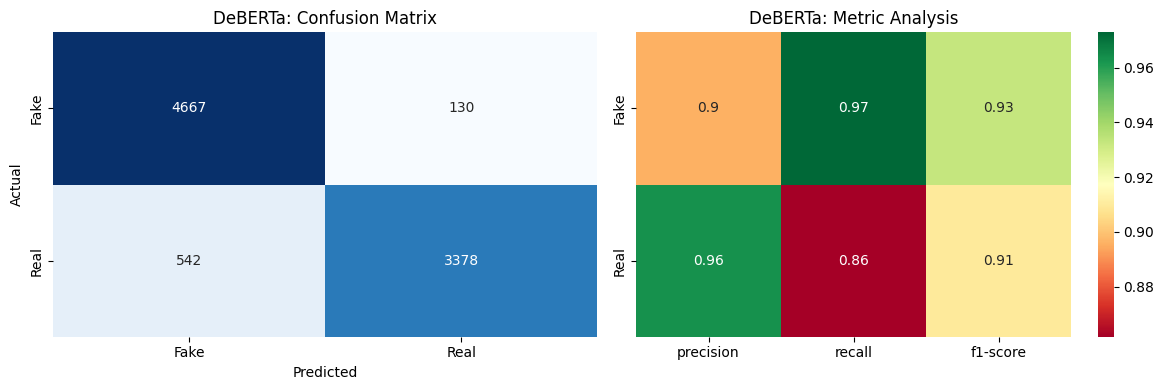

In [ ]:
# Evaluate DeBERTa on Test Set
model.eval()
deberta_preds = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing DeBERTa"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        deberta_preds.extend(preds.cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

# Generate Detailed Reports
print("\n" + 50*"-")
print(f"{'Final DeBERTa Model Results':^50}")
print(50*"-" + "\n")

report = classification_report(true_labels, deberta_preds, target_names=['Fake', 'Real'], output_dict=True)

# Textual Log
print(f"Model: DeBERTa v3 + LoRA")
print(f"{'-'*40}")
print(f"{'Class':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
for label in ['Fake', 'Real']:
    metrics = report[label]
    print(f"{label:<10} | {metrics['precision']:<7.4f}    | {metrics['recall']:<9.4f}  | {metrics['f1-score']:<7.4f}")
print(f"\nOverall Accuracy: {report['accuracy']:.4f}")

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix Heatmap
cm = confusion_matrix(true_labels, deberta_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
ax[0].set_title('DeBERTa: Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_xticklabels(['Fake', 'Real'])
ax[0].set_yticklabels(['Fake', 'Real'])

# Classification Metrics Heatmap
# Transpose and select only Fake/Real rows (exclude accuracy/macro avg) for cleaner heatmap
report_df = pd.DataFrame(report).iloc[:-1, :2].T
sns.heatmap(report_df, annot=True, cmap='RdYlGn', ax=ax[1], cbar=True)
ax[1].set_title('DeBERTa: Metric Analysis')

plt.tight_layout()
plt.show()